In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

sns.set_style("dark")

new line d2|"G"B3/2g/2d3/2B/2G3/2B/2d3/2B/2|"D"c3/2e/2a3/2g/2f3/2d/2e3/2f/2|
old line d2|: || |:"G"B3/2g/2d3/2B/2 G3/2B/2d3/2B/2|"D"c3/2e/2a3/2g/2 f3/2d/2e3/2f/2|\
----------
new line A/2|"D"d/2c/2d/2e/2fA|"G"Be"A"cA|"D"d/2c/2d/2e/2f/2e/2d/2c/2|"Em"Be"A"aA|
old line A/2|: || |:"D"d/2c/2d/2e/2 fA|"G"Be "A"cA|"D"d/2c/2d/2e/2 f/2e/2d/2c/2|"Em"Be "A"aA|
----------
new line f|"G"g3/2a/2"D"gf|"G"gd2e|"C"dc"D"BA|"G"BG2A|"G"B"Em"G2A/2B/2|
old line f|: || |:"G"g3/2a/2 "D"gf|"G"gd2e|"C"dc "D"BA|"G"BG2A|"G"B" Em"G2A/2B/2|\
----------
new line G/2|"C"c/2d/2e/2c/2"F"A/2c/2F|"C"c/2d/2e/2c/2"G"B/2d/2d|"C"e/2d/2c/2e/2"D"d/2c/2d/2c/2|"G"B/2c/2d/2g/2"C"e/2c/2c/2B/2|KG|"D"cA/2c/2"G"d/2B/2G/2B/2|"D"cA/2c/2"G"B/2d/2g/2d/2|
old line |: || |:"D"cA/2c/2 "G"d/2B/2G/2B/2|"D"cA/2c/2 "G"B/2d/2g/2d/2|\
----------
new line e|"D"fddcdd|"G"Bdd"A"Ace|"D"fddcdd|"Em"Bee"A"ede|
old line e|: || |:"D"fdd cdd|"G"Bdd "A"Ace|"D"fdd cdd|"Em"Bee "A"ede|
----------
new line d|"G"BddB|"C"ceec|"G"BddB|"Am"e/2d/2c/2B/2"D7"A2|"G"Bdd

/tmp/ipykernel_464/3641532070.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_songs_df.drop(chords_names_least_occurrences, axis=1, inplace=True)


<AxesSubplot: xlabel='chords', ylabel='count'>

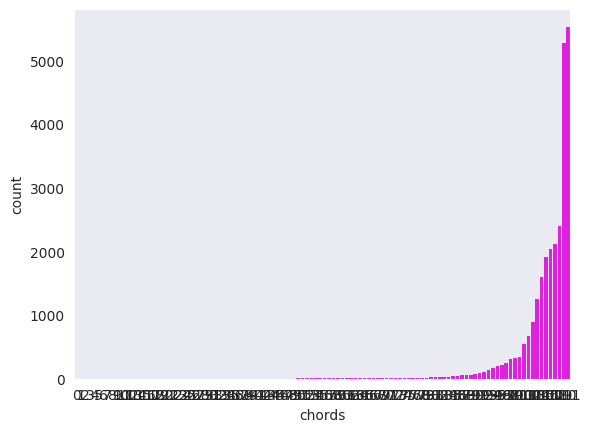

In [2]:
import os
import re
from collections import Counter

global control_var
control_var = True
def get_tuneBooks_file_names(path):
    tuneBook_filenames = []
    
    for tuneBook_name in os.listdir(path):
        if tuneBook_name.endswith('.abc'):
            tuneBook_filenames.append(tuneBook_name)
    
    #return ["jigs.abc"]
    return tuneBook_filenames
def split_abc_song(abc_song):
    k_index = abc_song.find('K:')

    split_index = abc_song.find('\n', k_index)

    header = abc_song[:split_index]
    body = abc_song[split_index+1:]
    return header, body

def tuneBook_to_dataframe(tuneBook):
    song_list = tuneBook.split("\n\n")
    song_list = [song.strip() for song in song_list]
    songs_header_body_format = [split_abc_song(song) for song in song_list if song != '']
    """
    for (h,b) in songs_header_body_format:
        print("header")
        print(h)
        print("*"*10)
        print("body")
        print(b)
        print("\n")
        print("-"*50)
        print("\n")
    """
    
    return pd.DataFrame(songs_header_body_format, columns=['header', 'body'])

def get_attributes_from_song_header(tuneBook_df,tuneBook_name):
    attributes_column = tuneBook_df["header"]
    attributes_list = list(attributes_column)
    
    data = []
    for string in attributes_list:
        song = {}
        for line in string.split("\n"):
            if not line.startswith("%"):
                if ':' in line:
                    key, value = line.split(":", maxsplit=1)
                    song[key.strip()] = value.strip()
        data.append(song)

    df = pd.DataFrame(data)
    descriptive_names = {
                        'X': 'reference_number',
                        'T': 'title',
                        'S': 'source',
                        'M': 'meter',
                        'L': 'unit_note_length',
                        'R': 'rhythm',
                        'P': 'parts',
                        'K': 'key',
                        'F': 'file_name',
                        'N': 'notes'
                        }
    df.rename(columns=descriptive_names, inplace=True)
    df["tuneBook"] = tuneBook_name
    df["original_header"] =  tuneBook_df["header"]
    df["original_body"] =  tuneBook_df["body"]
    
    return df

def get_chord_progression(song_body):
    bars = song_body.split("|")
    chord_progression = "|"
    for bar_content in bars:
        match_chords = r'"[^"]*"'
        chords = re.findall(match_chords, bar_content)
        bar_chords = ''.join(chords)
        if bar_chords != "":
            chord_progression += bar_chords +'|'
    return chord_progression

def get_chord_occurrences(song_body):
    bars = song_body.split("|")
    chord_progression = "|"
    match_chords = r'"[^"]*"'
    chords = [re.findall(match_chords, bar_content)  for bar_content in bars if bar_content]
    chords = [chord for bar_chords in chords for chord in bar_chords]
    chord_occurrences = dict(Counter(chords))
    return chord_occurrences

def get_chords_data(song_body=""):
    #song_body = 'P:A\nD|"Gm"GB2G|"D7"^Fd2D|"Gm"GB2G|"D7"^FA2D|"Gm"GB2G|"D"^Fg -"Cm"gc|\\\n"Gm/d"B2 "D7"A2|"Gm"G3:|\nP:B\nd|"Gm"dg2d|"Gm"gb2d|"F"cf2c|"F"fa2c|"Eb"Be2d/2c/2|"Gm"dg -"Cm"gc|\\\n"Gm/d"B2 "D7"A2|"Gm"G3:|'
    clean_body_song = ""
    match_pattern = ""
    for line in song_body.splitlines():
        #if not line.startswith("%"):
            #if not "P:" in line:
        if not line.startswith(('P:', 'M:', '%', "L:")):
            #print("Header detected!!!",line)
            new_line = line.strip("\\")
            match_pattern = r"[: ]"
            new_line = re.sub(match_pattern, "", new_line)
            clean_body_song = clean_body_song+new_line
            if('||||' in clean_body_song):
                match_pattern = r'\|\|\|\|'
                clean_body_song = re.sub(match_pattern, "|", clean_body_song)
                print("new line",clean_body_song)
                print("old line",line)
                print("-"*10)
    
    chord_progression = get_chord_progression(clean_body_song)
    chords_data = get_chord_occurrences(clean_body_song)
    chords_data["chord_progression"] = chord_progression
    chords_data["clean_body"] = clean_body_song
    return chords_data

### treat strings line by line to ignore comments and parts!!!!!
def get_song_characteristics_from_body(tuneBook_df, header_col_name="original_body"):
    songs_bodies=tuneBook_df[header_col_name]
    #global control_var
    #print(songs_bodies)
    #if(control_var):
        #control_var = False
    #df = tuneBook_df.join(songs_bodies.apply(get_chords_data))
    new_data = songs_bodies.apply(get_chords_data)
    chords_df = new_data.apply(pd.Series)
    chords = chords_df['chord_progression']
    chords_df = chords_df.drop('chord_progression', axis=1)
    chords_df["chord_progression"] = chords
    tuneBook_df = tuneBook_df.join(chords_df)
    #print(tuneBook_df.columns)
    #print("*"*20)   
    # get anacrusis bool to see that the dataset is balanced
    #tuneBook["num_notes_per_bar"] # count num -> useless? to measure intensity?
    #tuneBook["num_bars"] # count number of || ins song -> to detect possible outliers?
    #tuneBook["num_notes_in_song"] # count a,b,c,d...in string, match regex "a"   
    #tuneBook["chord_progression"] #string "|"C"|"Dm"|" -> to count chords and to have a "Tree view of common chord progressions"
    #tuneBook["multiple_parts"] #bool -> to treat songs with multiple parts
    ##  Count types of notes in each song to see the proportion of notes for a given key
    ## Maybe by chord also?
    return tuneBook_df
def get_songs_metadata(songs_dataframe, tuneBook_name):
    #songs_dataframe["number_in_tunebook"] = get_attributes_from_song_header(songs_dataframe)
    df = get_attributes_from_song_header(songs_dataframe,tuneBook_name)
    df = get_song_characteristics_from_body(df)
    return df

def get_chord_columns_as_occurrences(songs_df):
    chords_names = songs_df.columns[songs_df.columns.str.contains('"[^"]*"')]
    chords_occurrences = songs_df[chords_names].sum()
    return chords_occurrences



def drop_rows_by_chord_occurrence(songs_df,drop_threshold=100):
    
    chords_occurrences = get_chord_columns_as_occurrences(songs_df)
    ## Gets the names of the chords that appear less times than the threshold.
    chords_names_least_occurrences = chords_occurrences[chords_occurrences<drop_threshold].index.to_list()
    print("number chords least occurrences: ",len(chords_names_least_occurrences))
    print("chords least occurrences",chords_names_least_occurrences)

    ## Applies a logical OR to the selected columns in order to drop the rows that have a value in the corresponding column
    mask_drop_songs_with_low_chords_sample = songs_df[chords_names_least_occurrences].apply(lambda row: row>0).any(axis=1)
    drop_num = mask_drop_songs_with_low_chords_sample.value_counts()
    print("number of values to be dropped:\n",drop_num)

    ##Apply the negative mask to preserve the rows that don't have occurrences of the selected chords
    clean_songs_df = songs_df[~mask_drop_songs_with_low_chords_sample]

    ##Drop columns of useless chords
    clean_songs_df.drop(chords_names_least_occurrences, axis=1, inplace=True)
    clean_songs_df = clean_songs_df.reset_index(drop=True)

    return clean_songs_df

def drop_rows_by_extended_chords(songs_df,chords_to_drop=[]):
    
    chords_occurrences = get_chord_columns_as_occurrences(songs_df)

    ## Gets the names of the chords that have '/' 
    extended_chords_names = songs_df.columns[songs_df.columns.str.contains("/")].to_list()
    extended_chords_names = extended_chords_names + chords_to_drop

    ## Applies a logical OR to the selected columns in order to drop the rows that have a value in the corresponding column
    mask_drop_songs_with_extended_chords = songs_df[extended_chords_names].apply(lambda row: row>0).any(axis=1)
    drop_num = mask_drop_songs_with_extended_chords.value_counts()
    print("number of values to be dropped:\n",drop_num)

    ##Apply the negative mask to preserve the rows that don't have occurrences of the selected chords
    clean_songs_df = songs_df[~mask_drop_songs_with_extended_chords]

    ##Drop columns of useless chords
    clean_songs_df.drop(extended_chords_names, axis=1, inplace=True)
    clean_songs_df = clean_songs_df.reset_index(drop=True)

    return clean_songs_df

def prepare_dataset_for_EDA(relative_path="",drop_by_occurrences=True, drop_by_extended_chord=False, min_chord_progression_length=20):
    absolute_path = os.getcwd()
    #relative_path = "notebooks/data/NottinghamData/nottingham_database"
    relative_path = "notebooks/data/NottinghamCleaned/nottingham_match/python/data/nottingham_jukedeck/ABC_cleaned"
    absolute_path = os.path.join(absolute_path, relative_path)
    songs_df = pd.DataFrame()
    list_tuneBooks = get_tuneBooks_file_names(absolute_path)
    for abc_tuneBook_filename in list_tuneBooks:
        file_path = os.path.join(absolute_path, abc_tuneBook_filename)
        
        with open(file_path) as tuneBook:
            contents = tuneBook.read()
            df = tuneBook_to_dataframe(contents)
            df1 = get_songs_metadata(df,abc_tuneBook_filename)
            songs_df = pd.concat([songs_df, df1], ignore_index=True)

    ## Sets chords columns as int types
    chords_names = songs_df.columns[songs_df.columns.str.contains('"[^"]*"')]
    songs_df[chords_names] = songs_df[chords_names].fillna(0).astype(int)


    chords_occurrences = songs_df[chords_names].sum().sort_values(ascending=True)

    chords_occurrences = chords_occurrences.reset_index(drop=True)
    chords_occurrences = chords_occurrences.reset_index()
    chords_occurrences_before_drop = chords_occurrences.rename({0:"count","index":"chords"},axis=1)
    
    clean_songs_df = songs_df

    if(drop_by_occurrences):
        clean_songs_df = drop_rows_by_chord_occurrence(clean_songs_df)
    #chords_most_occurrences = songs_df[chords_names_least_occurrences].sum().sort_values(ascending=True)
    #for current_chord,sum_chords in chords_most_occurrences.items():
    #    print(current_chord,sum_chords)

    if(drop_by_extended_chord):
        clean_songs_df = drop_rows_by_chord_occurrence(clean_songs_df)

    ## Drops rows that don't have the minimum chord progression length
    mask_no_chord_progression = clean_songs_df["chord_progression"].str.len()>min_chord_progression_length
    clean_songs_df = clean_songs_df[mask_no_chord_progression]
    clean_songs_df = clean_songs_df.reset_index(drop=True)
    #for song in clean_songs_df["chord_progression"]:
    #    print(song)
    #    print("**"*10)
    return songs_df, clean_songs_df, chords_occurrences_before_drop

songs_df, clean_songs_df,chords_occurrences = prepare_dataset_for_EDA()
#chords_occurrences["count"] = chords_occurrences["count"].apply(np.log)
sns.barplot(data=chords_occurrences,y="count", x='chords',edgecolor='none',color="magenta")


In [3]:
songs_df["original_body"].str.contains("P:")

0        True
1        True
2       False
3       False
4        True
        ...  
1029    False
1030    False
1031     True
1032    False
1033    False
Name: original_body, Length: 1034, dtype: bool

Index(['index', 0], dtype='object')


<AxesSubplot: xlabel='0', ylabel='index'>

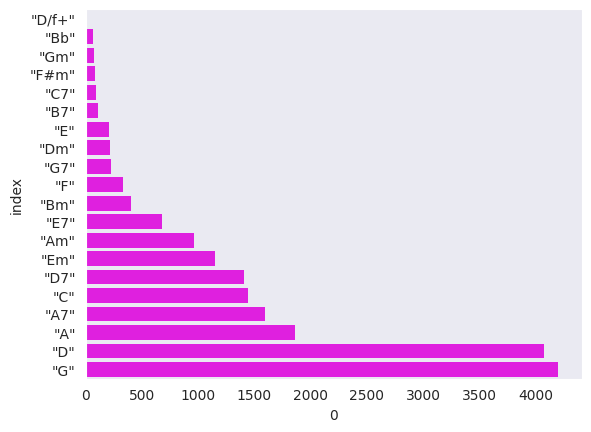

In [4]:
chords_names = clean_songs_df.columns[clean_songs_df.columns.str.contains('"[^"]*"')]

chords_occurrences_df = clean_songs_df[chords_names].sum().sort_values(ascending=True).reset_index()
print(chords_occurrences_df.columns)
sns.barplot(data=chords_occurrences_df,y="index", x=0,edgecolor='none',color="magenta")

<AxesSubplot: xlabel='key', ylabel='Count'>

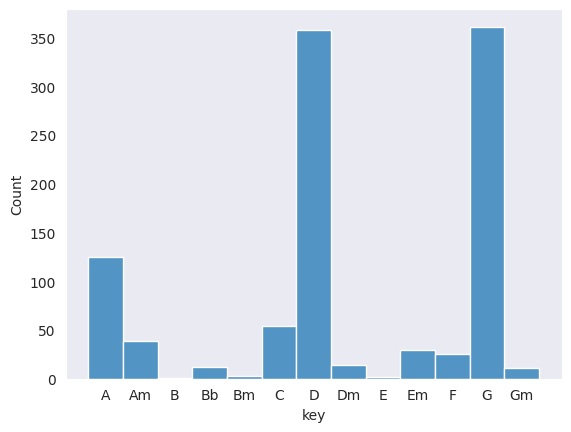

In [5]:
sns.histplot(songs_df["key"].astype("category"))

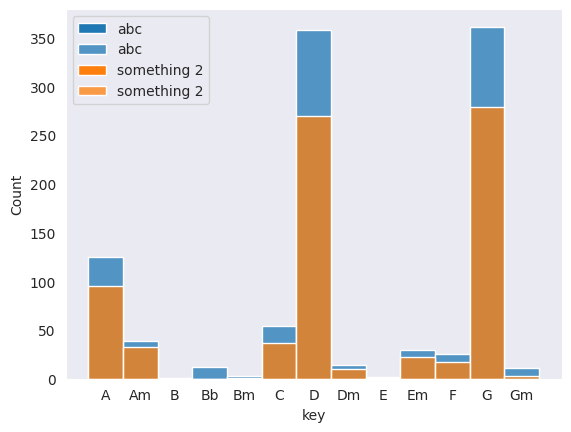

In [6]:
#fig, ax = plt.subplots()
ax = sns.histplot(songs_df["key"].astype("category"),label="abc")
ax = sns.histplot(clean_songs_df["key"].astype("category"), ax=ax,label="something 2")
ax.legend()
plt.show()

In [7]:
clean_songs_df.columns[clean_songs_df.columns.str.contains('"[\(]')]

Index([], dtype='object')

In [8]:
chord_names = clean_songs_df.columns[clean_songs_df.columns.str.contains('"')].to_list()
chords = "|"
for chord_name in chord_names:
    chords = chords+chord_name+'|'
    print(chord_name)
print(chords)

"Gm"
"D7"
"D"
"F"
"G"
"Em"
"C"
"Am"
"D/f+"
"A7"
"F#m"
"Bm"
"Bb"
"A"
"E7"
"G7"
"Dm"
"C7"
"E"
"B7"
|"Gm"|"D7"|"D"|"F"|"G"|"Em"|"C"|"Am"|"D/f+"|"A7"|"F#m"|"Bm"|"Bb"|"A"|"E7"|"G7"|"Dm"|"C7"|"E"|"B7"|


In [9]:
print(clean_songs_df["chord_progression"].str.contains("segno").value_counts())

False    767
Name: chord_progression, dtype: int64


In [10]:
print(songs_df["chord_progression"].str.contains("segno").value_counts())

False    1034
Name: chord_progression, dtype: int64


In [11]:
for song,title,book in zip(clean_songs_df["clean_body"],clean_songs_df["title"],clean_songs_df["tuneBook"]):
    print(title," ", book)
    print(song)
    print("**"*10)

The Indian Queen   playford.abc
f/2g/2|"D"afdf|"A7"e2A2|"D"FAAf|"Em"e2-"A7"ef/2g/2|"D"afdf|"A7"e2A2|"D"FAAf|"D"d3|c/2d/2|"A"e/2d/2c/2B/2Ae|"F#m"fc"Bm"dB|"D"f/2g/2a"E7"b^g|"A7"a3e/2f/2|"G"g/2f/2e/2d/2"A"ca|"Em"Bg"A7"Af/2g/2|"G"ed"A7"ec|"D"d3|
********************
Nancy's Fancy   playford.abc
|D|"G"GBBA/2B/2|"D7"cAAd|"G"BGGB|"Am"A/2G/2F/2E/2"D7"DD|"G"GB"Em"BA/2B/2|"Am"cA"D7"Ad|"G"BG"D7"AF|"G"G2G||g|fedc|"G"BAGB|"G"dgdB|"D"B2Ag|fedc|BABc|"G"dg"D7"fd|"G"g2g2|"Em"BBB/2A/2B|"Am"ccc/2B/2c|"Em"BBB/2A/2B|"D7"A/2G/2F/2E/2DD|"Em"BBB/2A/2B|"Am"ccc/2B/2c|"Em"BG"D7"AF|"G"G2G|
********************
Never Love Thee More   playford.abc
"G"DEDG2A|"G"BcBA2G|"G7"dB2A2G|"C"E3-E3|"G"DEDG2A|"G"BcBA2G|"G"dB2c2d|"C"e3-e2e|"G"dB2A2G|"C"c2dedc|"G"dBc"C"A2G|"Am"E3"D7"G2E|"G"DEDG2A|"G"Bcd"C"edc|"Am"dBc"D7"A2G|"G"G3-G2||
********************
Nonesuch   playford.abc
a|"Dm"afga|"Dm"fe/2f/2da|"Dm"afga|"Dm"f2fa|"F"afga|"Dm"fe/2f/2da|"F"afga|"Dm"f2de|"C"ecde|"Dm"fe/2f/2de|"Am"ecde|"Dm"f2de|"C"ecde|"Dm"fe/2f/2de|"Am"ecde|

In [12]:
descriptive_names = {
                        'X': 'reference_number',
                        'T': 'title',
                        'S': 'source',
                        'M': 'meter',
                        'L': 'unit_note_length',
                        'R': 'rhythm',
                        'P': 'parts',
                        'K': 'key',
                        'F': 'file_name',
                        'N': 'notes'
                        }

4/4    426
6/8    262
2/4     33
3/4     31
9/8      8
2/2      5
6/4      1
Name: meter, dtype: int64

Sum of values: 766

NaN values: 1


<AxesSubplot: xlabel='meter', ylabel='Count'>

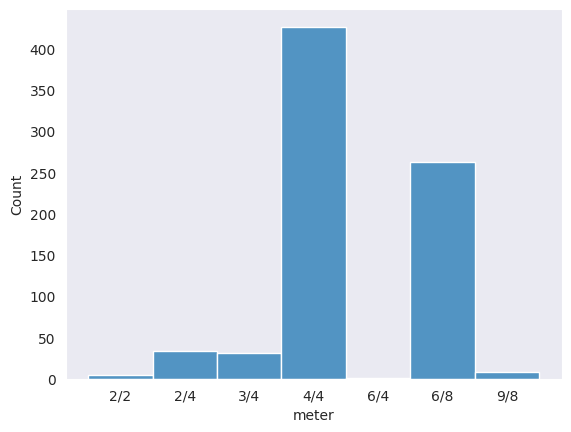

In [13]:
category_name = "meter"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
sns.histplot(clean_songs_df[category_name].astype("category"))

Hornpipe    57
Name: rhythm, dtype: int64

Sum of values: 57

NaN values: 710


<AxesSubplot: xlabel='rhythm', ylabel='Count'>

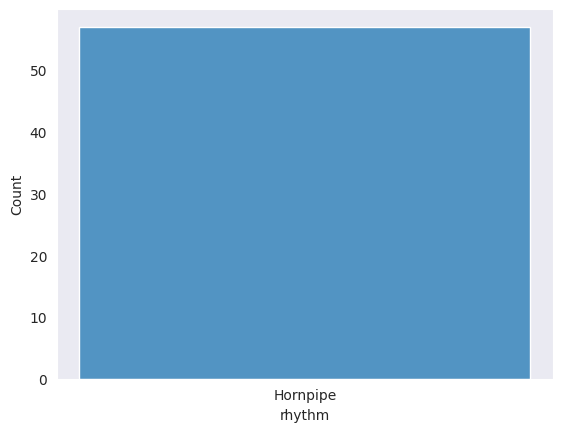

In [14]:
category_name = "rhythm"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
sns.histplot(clean_songs_df[category_name].astype("category"))

1/4    423
1/8     64
Name: unit_note_length, dtype: int64

Sum of values: 487

NaN values: 280


<AxesSubplot: xlabel='unit_note_length', ylabel='Count'>

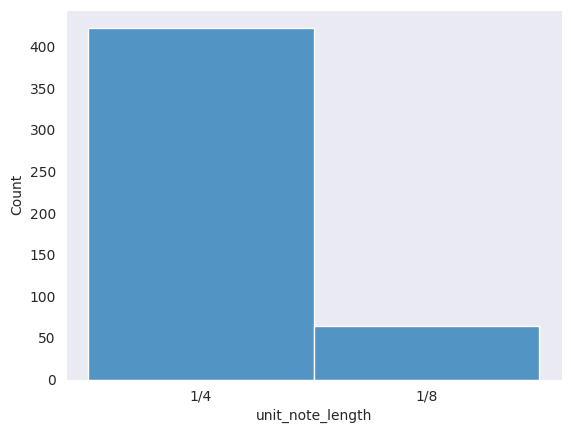

In [15]:
category_name = "unit_note_length"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
sns.histplot(clean_songs_df[category_name].astype("category"))

G     279
D     269
A      95
C      37
Am     33
Em     22
F      17
Dm     10
Gm      3
Bm      1
E       1
Name: key, dtype: int64

Sum of values: 767

NaN values: 0


<AxesSubplot: xlabel='key', ylabel='Count'>

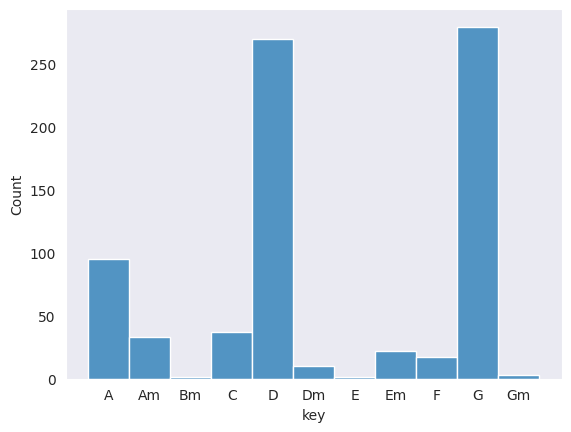

In [16]:
category_name = "key"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
sns.histplot(clean_songs_df[category_name].astype("category"))

jigs.abc        244
reelsr-t.abc     72
reelsd-g.abc     67
reelsa-c.abc     65
reelsh-l.abc     65
reelsm-q.abc     62
hpps.abc         57
ashover.abc      39
reelsu-z.abc     26
waltzes.abc      26
morris.abc       18
playford.abc      9
slip.abc          9
xmas.abc          8
Name: tuneBook, dtype: int64

Sum of values: 767

NaN values: 0


<AxesSubplot: xlabel='Count', ylabel='tuneBook'>

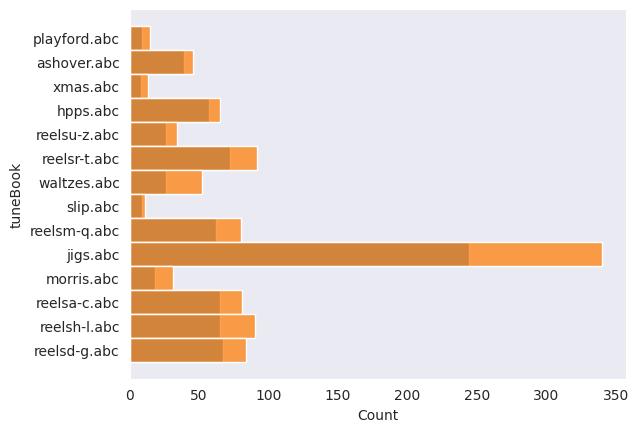

In [17]:
category_name = "tuneBook"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
sns.histplot(clean_songs_df, y=category_name)
sns.histplot(songs_df, y=category_name)